In [1]:
import glob
import os
import json
import dpath
import zlib
import base64

import numpy as np

CANCER_NODULES_DATASET_DIR = '/media/vlermakov/data/UCSDNodules/Metastatic/'
PHONETIC_ID = 'Prutigu'
PATCH_ID = '62c10f05d4ca3408fb0fcfde-c42a3d86110532f3-1' 
# PHONETIC_ID = 'Gehienes'
# PATCH_ID = '62c10f288b78c508ff535992-15f75695855943ff-1' 

# Get json files in the segmentation subfolder that start with the phonetic_id
json_files = glob.glob(os.path.join(CANCER_NODULES_DATASET_DIR, "segmentation", PHONETIC_ID + "*.json"))

patch_id_stub = PATCH_ID.rsplit("-",1)[0]

# Get the json file that has the patch_id_stub in it
json_file = [json_file for json_file in json_files if patch_id_stub in open(json_file).read()][0]


In [2]:
patch_data = None
decompressed_data = None
target_volume = np.zeros((512,512,512))
tmp_buffer =None

# Open the json file and parse it
with open(json_file) as f:
    data = json.load(f)

    # Search for all occurrences of the key "patches" in the data
    found = dpath.search(data, '**/patches', yielded=True)

    # Iterate through all child elements of each "patches"
    for path, patches in found:
        for patch in patches:
            # If fields are not defined then skip this patch
            if patch['id'] is None or patch['height'] is None or patch['width'] is None or patch['depth'] is None:
                continue
                

            # Get the center of the nodule in the target volume
            x = int(patch["position"][0])
            y = int(patch["position"][1])
            z = int(patch["position"][2])
            
            if patch['id'] == PATCH_ID:
                print(f"patch: {z},{y},{x}")


            # Decode the Base64 string to bytes
            compressed_data = base64.b64decode(patch["binary"])

            # Decompress using zlib
            decompressed_data = zlib.decompress(compressed_data)
            decompressed_data = np.frombuffer(decompressed_data, dtype=np.uint8)

            decompressed_data = np.array(decompressed_data > 0, dtype=np.int8)

            # Reshape the data based on height, width and depth in the patch
            patch_data = decompressed_data.reshape((patch['depth'],patch['height'],patch['width']))


            # Inscribe the patch into the target volume, setting 1 where 1 is in the patch, making sure to not overwrite existing values
            target_volume[z:z+patch['depth'],y:y+patch['height'],x:x+patch['width']] = np.maximum(target_volume[z:z+patch['depth'],y:y+patch['height'],x:x+patch['width']],patch_data)
    
            tmp_buffer = np.zeros(target_volume.shape,dtype=np.int8)
            tmp_buffer[z:z+patch['depth'],y:y+patch['height'],x:x+patch['width']] = patch_data



patch: 428,230,150


In [3]:
display_volume = target_volume[428:428+64,230:230+64,150:150+64]

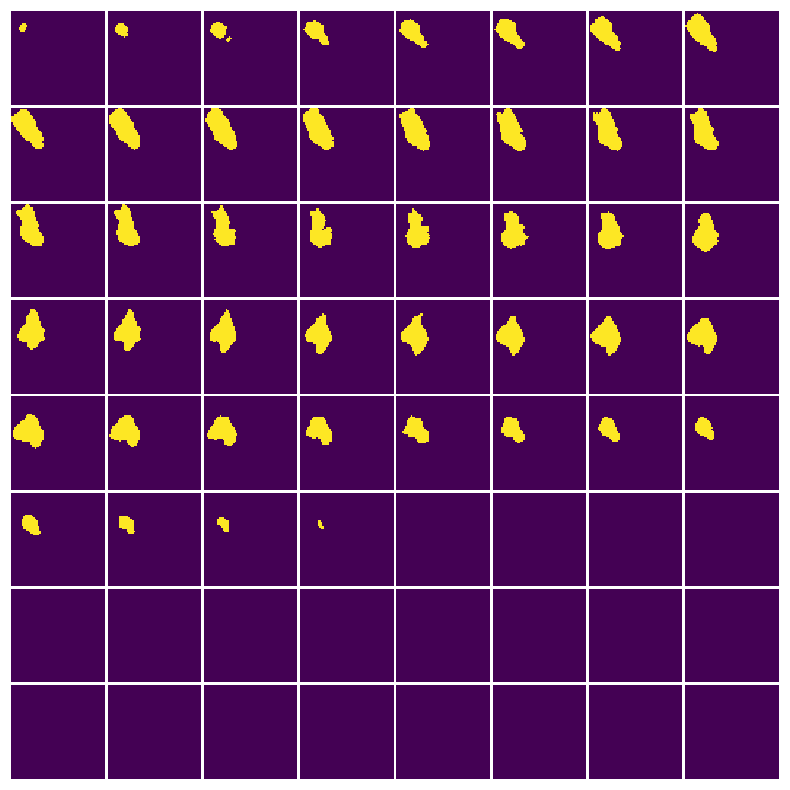

In [4]:
from monai.visualize.utils import matshow3d
import matplotlib.pyplot as plt

fig1 = plt.figure()
matshow3d(display_volume, channel_dim = None, fig = fig1, frame_dim=-1)
plt.show()